In [1]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
np.set_printoptions(threshold=np.inf)
plt.rcParams['figure.figsize'] = [9,9]
from numpy import linalg as LA

In [2]:
N_features = 4                  # Number of features
N_Samples = 10000               # Number of Samples
N_labels = 2                    # Number of classes

# Mean vectors
mean_matrix = np.ones(shape=[N_labels, N_features])
mean_matrix [0, :] = [-1,-1,-1,-1]

# Covariance matrices
covariance_matrix = np.ones(shape=[N_labels, N_features, N_features])
covariance_matrix [0, :, :] = [[2, -0.5, 0.3, 0],[-0.5, 1, -0.5, 0], [0.3, -0.5, 1, 0], [0, 0, 0, 2]]
covariance_matrix [1, :, :] = [[1, 0.3, -0.2, 0], [0.3, 2, 0.3, 0], [-0.2, 0.3, 1, 0], [0, 0, 0, 3]]

In [4]:
#Seed to obtain same results for random numbers
np.random.seed(10) 

# Class Priors and assigning labels
priors = [0.65, 0.35]
label = (np.random.rand(N_Samples) >= priors[1]).astype(int)

In [5]:
# Generate gaussian distribution for 10000 samples using mean and covariance matrices for each label
X = np.zeros(shape = [N_Samples, N_features])
for i in range(N_Samples): 
        if (label[i] == 0):
                X[i, :] = np.random.multivariate_normal(mean_matrix[0, :], covariance_matrix[0, :,:])
        elif (label[i] == 1):
                X[i, :] = np.random.multivariate_normal(mean_matrix[1, :], covariance_matrix[1, :,:])

# Compute between-class and within-class scatter matrices
Sb = (mean_matrix[0, :] - mean_matrix[1, :]) * np.transpose (mean_matrix[0, :] - mean_matrix[1, :])
Sw = covariance_matrix[0, :, :] + covariance_matrix[1, :, :]

# Eigenvalues and eigen vectors of inverse(Sw.Sb)
V, W = LA.eig(LA.inv(Sw) * Sb)

In [6]:
# Eigen vector with maximizing optimization objective
W_LDA = W[np.argmax(V)]
X0 = X[np.where(label == 0)]
X1 = X[np.where(label == 1)]

# Data projection using wLDA
Y0 = np.zeros(len(X0))
Y1 = np.zeros(len(X1))
Y0 = np.dot(np.transpose(W_LDA), np.transpose(X0))
Y1 = np.dot(np.transpose(W_LDA), np.transpose(X1))

# Ranging threshold from minimum to maximum
Y = np.concatenate([Y0, Y1])
sort_Y = np.sort(Y)
tau_sweep = []

In [7]:
# Calculate mid-points which will be used as threshold values
for i in range(0,9999):
        tau_sweep.append((sort_Y[i] + sort_Y[i+1])/2.0)

# Array initialization for results
decision = []
TP = [None] * len(tau_sweep)
FP = [None] * len(tau_sweep)
minPerror = [None] * len(tau_sweep)

# Classify for each threshold and compute error and evaluation metrics
for (index, tau) in enumerate(tau_sweep):
        decision = (Y >= tau)
        TP[index] = (np.size(np.where((decision == 1) & (label == 1))))/np.size(np.where(label == 1))
        FP[index] = (np.size(np.where((decision == 1) & (label == 0))))/np.size(np.where(label == 0))
        minPerror[index] = (priors[0] * FP[index]) + (priors[1] * (1 - TP[index]))

In [8]:

# Theoretical classification based on class priors
gamma_ideal = priors[0] / priors[1]
ideal_decision = (Y >= gamma_ideal)
TP_ideal = (np.size(np.where((ideal_decision == 1) & (label == 1))))/np.size(np.where(label == 1))
FP_ideal = (np.size(np.where((ideal_decision == 1) & (label == 0))))/np.size(np.where(label == 0))
minPerror_ideal = (priors[0] * FP_ideal) + (priors[1] * (1 - TP_ideal))
print("Tau Ideal - %f and corresponding minimum error %f" %(gamma_ideal, minPerror_ideal))

Tau Ideal - 1.857143 and corresponding minimum error 0.376001


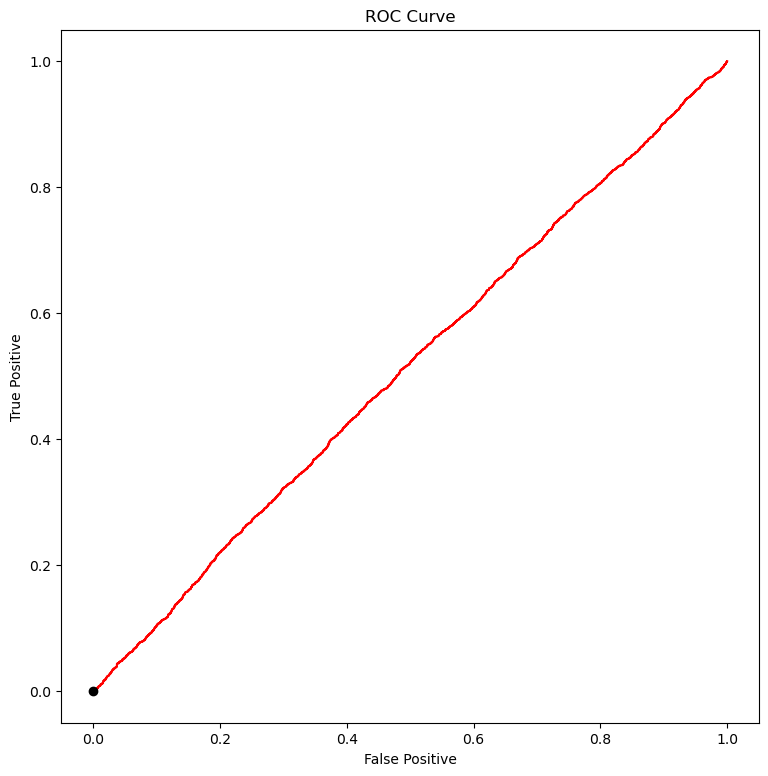

In [9]:
# Plot ROC curve
plt.plot(FP, TP, color = 'red')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.plot(FP[np.argmin(minPerror)], TP[np.argmin(minPerror)],'o',color = 'black')
plt.show()

In [10]:
print("Tau Practical - %f and corresponding minimum error %f"%(tau_sweep[np.argmin(minPerror)], np.min(minPerror)))

Tau Practical - 4.607466 and corresponding minimum error 0.350179
